In [124]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.visualization.util import default_number_to_text
from pymoo.problems.functional import FunctionalProblem
from pymoo.core.problem import Problem
from pymoo.termination import get_termination
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.expx import ExponentialCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import SBX

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import copy
import numpy as np
import tensorflow as tf
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix

from collections import defaultdict
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import pandas as pd

In [4]:
ratings_df = pd.read_csv('datasets/ml-latest-small/ratings.csv', encoding='latin-1')

In [5]:
model = DCN()
model.fit(ratings_df)

In [10]:
def get_user_info(user_id):

    all_movies = ratings_df['movieId'].unique()
    movies_rated = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    
    # Movies not rated by the user
    movies_not_rated = set(all_movies) - set(movies_rated)
    
    # Convert to a list
    candidates = list(movies_not_rated)
    
    predictions = {}
    for movie_id in candidates:
        predictions[movie_id] = model._predict_single(user_id, movie_id)
    df = pd.DataFrame(list(predictions.items()), columns=['movieId', 'predictedRating'])
    df = df.sort_values(by='predictedRating', ascending=False)
    return df

    rating_counts = ratings_df['movieId'].value_counts()

    # Create a DataFrame with movieId and novelty indicator (1 if novel, 0 otherwise)
    novelty_df = pd.DataFrame({
        'is_novel': (rating_counts < 16).astype(int)
    })
    all_info = pd.merge(df, novelty_df, on='movieId', how='left')
    all_info = pd.merge(all_info, rating_counts, on='movieId', how='left')
    return all_info

In [71]:
user_info = get_user_info(1)

In [80]:
pivot = ratings_df.pivot(index='movieId',columns='userId', values='rating').fillna(0)
item_similarity = cosine_similarity(pivot)

In [77]:
class MovieSelectionProblem(Problem):

    def __init__(self, final_df, user_info):
        self.final_df = final_df
        self.user_info = user_info
        super().__init__(n_var=10,  # Variables are the indices of the selected movies
                         n_obj=4,   # Number of objectives
                         n_constr=1,  # No constraints for this problem
                         xl=0,     # Lower bound of the indices
                         xu=len(user_info) - 1,  # Upper bound of the indices
                         type_var=int)  # Indices are integers

    def _sim_func(self, m, n):
        m = pivot.index.get_loc(m)
        n = pivot.index.get_loc(n)
        return item_similarity[m][n]

    def _evaluate(self, X, out, *args, **kwargs):
        def calculate_diversity(indices):
            movie_ids = self.user_info.iloc[indices]["movieId"].values
            
            numerator = sum(self._sim_func(m, n) for i, m in enumerate(movie_ids) for j, n in enumerate(movie_ids) if i != j)
            denominator = 0.5 * len(indices) * (len(indices) - 1)
            diversity = 1 - (numerator / denominator)
            return diversity
        
        def calculate_coverage(indices):
            movie_ids = self.user_info.iloc[indices]["movieId"].values
            filtered_df = self.final_df[self.final_df['movieId'].isin(movie_ids)]
            unique_users = filtered_df['userId'].nunique()
            percentage_cov = (unique_users/self.final_df['userId'].nunique()) * 100
            return percentage_cov

        def calculate_novelty(indices):
            filtered_df = self.user_info.loc[indices]
            novel_count = filtered_df['is_novel'].sum()
            total_count = len(filtered_df)
            percentage_novel = float((float(novel_count) / float(total_count)) * 100)
            return percentage_novel
            
        objs = np.zeros((X.shape[0], self.n_obj))
        
        for i, indices in enumerate(X):
            
            selected_movies = self.user_info.iloc[indices]
            
            predicted_ratings_sum = selected_movies['predictedRating'].sum()
            coverage = calculate_coverage(indices)
            novelty = calculate_novelty(indices)
            diversity = calculate_diversity(indices)
            
            objs[i, 0] = -predicted_ratings_sum  # We negate because NSGA-II minimizes
            objs[i, 1] = -coverage              # We negate because NSGA-II minimizes
            objs[i, 2] = -novelty               # We negate because NSGA-II minimizes
            objs[i, 3] = -diversity
            
        out["F"] = objs

        g = np.array([self.check_repeats(solution) for solution in X])
        out["G"] = g.reshape(-1, 1)
    
    def check_repeats(self, solution):
        # Check for repeated integers
        return 0 if len(set(solution)) == len(solution) else 1

# Depending on your setup, you may also need to ensure the type consistency
class IntegerPolynomialMutation(PolynomialMutation):    
    def _do(self, problem, X, **kwargs):
        X = super()._do(problem, X, **kwargs)
        X = np.clip(np.round(X), problem.xl, problem.xu).astype(int)
        return X

class IntegerSBX(SBX):
    
    def _do(self, problem, X, **kwargs):
        X = super()._do(problem, X, **kwargs)
        X = np.clip(np.round(X), problem.xl, problem.xu).astype(int)
        return X

In [115]:
def run(final_df, user_info):
    problem = MovieSelectionProblem(ratings_df, user_info.head(200))
    
    algorithm = NSGA2(pop_size=100, sampling=IntegerRandomSampling(),
                     mutation=IntegerPolynomialMutation(),
                     crossover=IntegerSBX(eta=15, prob=0.9))
    
    termination = get_termination("n_gen", 100)
    
    res = minimize(problem, algorithm, termination, seed=1,
                   save_history=True, verbose=True)
    
    print("Optimal selection of movies indices:\n", res.X)
    print("Objective values:\n", -res.F)
    
    weights = [1, 5, 2, 1]
    weighted_sums = []
    
    for i in range(len(res.F)):
        weighted_sum = sum(weights[j] * (-res.F[i][j]) for j in range(len(weights)))
        weighted_sums.append(weighted_sum)
    
    # Get the index of the best weighted sum
    best_solution_index = weighted_sums.index(max(weighted_sums))
    print("Chosen optimal selection of movies indices:\n", res.X[best_solution_index])
    print("Corresponding objective values:\n", -res.F[best_solution_index])
    #return (res.X[best_solution_index], -res.F[best_solution_index])

In [123]:
run(ratings_df, user_info)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     25 |  0.000000E+00 |  0.1500000000 |             - |             -
     2 |      200 |     32 |  0.000000E+00 |  0.000000E+00 |  0.1890117633 |         ideal
     3 |      300 |     39 |  0.000000E+00 |  0.000000E+00 |  0.1324375850 |         ideal
     4 |      400 |     61 |  0.000000E+00 |  0.000000E+00 |  0.0242424242 |         ideal
     5 |      500 |     63 |  0.000000E+00 |  0.000000E+00 |  0.1428571429 |         nadir
     6 |      600 |     71 |  0.000000E+00 |  0.000000E+00 |  0.0803571429 |         ideal
     7 |      700 |     69 |  0.000000E+00 |  0.000000E+00 |  0.0756840866 |         ideal
     8 |      800 |     67 |  0.000000E+00 |  0.000000E+00 |  0.1302779585 |         nadir
     9 |      900 |     71 |  0.000000E+00 |  0.000000E+00 |  0.0801162113 |         nadir
    10 |     1000 |     67 |  0.000000E+00 |  0.000000E+00 |  0.0431202734 |             f

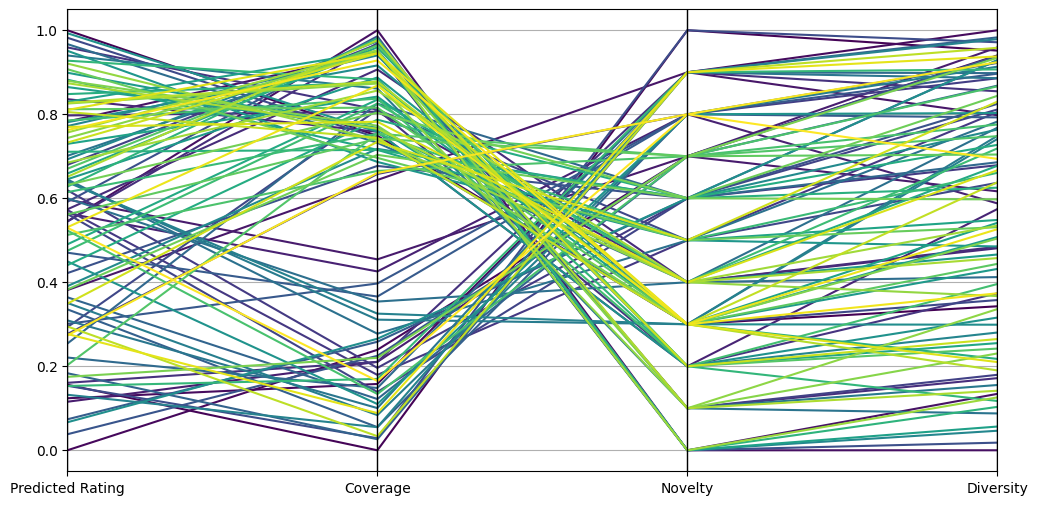

In [120]:
from sklearn.preprocessing import MinMaxScaler

data = -res.F

df = pd.DataFrame(data, columns=["Predicted Rating", "Coverage", "Novelty", "Diversity"])

# Normalize data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Add an 'ID' column for unique identifiers
df_scaled['ID'] = df_scaled.index.astype(str)

# Plot Parallel Coordinates Plot without class_column
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df_scaled, class_column='ID', color=plt.cm.viridis(np.linspace(0, 1, len(df_scaled))))
plt.legend().remove()
# Save and show plot
plt.show()

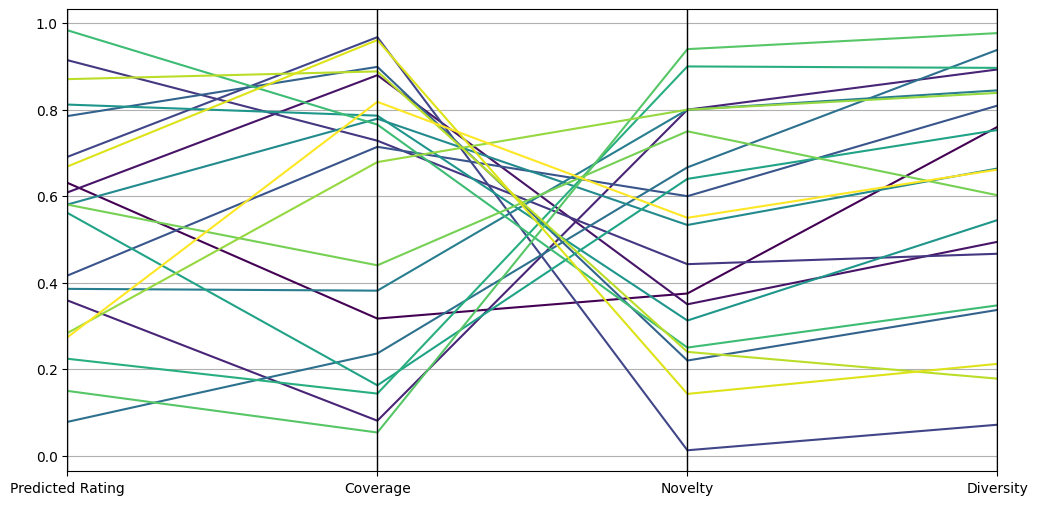

In [122]:
from sklearn.cluster import KMeans

data = -res.F

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Predicted Rating", "Coverage", "Novelty", "Diversity"])

# Normalize data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Determine the number of clusters
n_clusters = 20

# Applying KMeans Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled)

# Getting the cluster centers (centroids)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns)

# Plot Parallel Coordinates Plot for centroids
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(centroids.assign(ClusterID=centroids.index.astype(str)), class_column='ClusterID', color=plt.cm.viridis(np.linspace(0, 1, n_clusters)))

plt.legend().remove()
plt.show()